# Zeros analysis

In [3]:
import pickle

with open(f"real_performance_full_50_generated_train_graphs_30_seeds.pickle",'rb') as f:
    data = pickle.load(f)

for g in list(data.keys()):
    
    r = data[g]['LFR'][f'{list(data[g]["LFR"].keys())[0]}']['real']
    n = len(r)

    zeros = 0
    for v in r:
        if v == 0:
            zeros += 1

    print(f"Graph: {g}, Nodes: {n}, Found zeros (bet): {zeros} ({zeros/n*100} %), No zeros: {n-zeros} ({(n-zeros)/n*100} %)")

Graph: 1-wiki-Vote, Nodes: 7115, Found zeros (bet): 4711 (66.21222768798314 %), No zeros: 2404 (33.78777231201687 %)
Graph: 2-soc-Epinions, Nodes: 75879, Found zeros (bet): 50540 (66.60604383294456 %), No zeros: 25339 (33.39395616705544 %)
Graph: 3-email-EuAll, Nodes: 265214, Found zeros (bet): 258884 (97.61324816940282 %), No zeros: 6330 (2.386751830597178 %)


# Define metric functions

In [2]:
from scipy.stats import kendalltau,pearsonr
import math

def rbo(S,T, p= 0.9):
    
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def nozeros(a,b):
    aout = []
    bout = []
    
    for idx,v in enumerate(b):
        if v != 0:
            aout.append(a[idx])
            bout.append(b[idx])
    
    return aout,bout

def metrics(pred_results,real_results, graph, positions=[],mlist={'equal':True,'in_top':True,'rbo':True,'fullkendall':True,'nozeroskendall':True}):

    n = len(pred_results)
    assert n == len(real_results)

    nodes_sorted_pred = sorted(range(n),reverse=True,key=lambda k: pred_results[k])
    nodes_sorted_real = sorted(range(n),reverse=True,key=lambda k: real_results[k])
    
    m_dict = {'equal':{},'in_top':{},'rbo':{}}
    
    if positions == []:
        if graph == '3-email-EuAll':
            percentages = range(1,11)
        else:
            percentages = range(1,101)
        values = []
        for p in percentages:
            values.append(int(p*n/100))
            for k in m_dict.keys():
                m_dict[k][p] = []
    
    else:

        values = positions
        for p in positions:
            for k in m_dict.keys():
                m_dict[k][p] = []

    #fullkendall
    if mlist['fullkendall']:
        m_dict['fullkendall'] = kendalltau(pred_results,real_results)

    # nozeros
    if mlist['nozeroskendall']:
        a,b = nozeros(pred_results,real_results)
        m_dict['nozeroskendall'] = kendalltau(a,b)

    # nodos igual posicion top
    if mlist['equal']:
        for idx, p in enumerate(values):
            print(f"Coincident: {idx}",end='\r')
            c = 0
            for j in range(p):
                if nodes_sorted_pred[j] == nodes_sorted_real[j]:
                    c += 1
            if len(positions) == 0:
                m_dict['equal'][percentages[idx]].append(round(c/p*100,4))
            else:
                m_dict['equal'][p].append(round(c/p*100,4))

    # nodos acertados top
    if mlist['in_top']:
        for idx, p in enumerate(values):
            print(f"In top: {idx}",end='\r')
            a = sum(1 for item in nodes_sorted_pred[:p] if item in nodes_sorted_real[:p])
            if len(positions) == 0:
                m_dict['in_top'][percentages[idx]].append(round(a/p*100,4))
            else:
                m_dict['in_top'][p].append(round(a/p*100,4))
    
#    # Pearson correlation
#    if mlist['pearson']:
#        for idx, p in enumerate(values):
#            print(f"Pearson: {idx}",end='\r')
#            pear = pearsonr(nodes_sorted_pred[:p],nodes_sorted_real[:p])
#            if len(positions) == 0:
#                m_dict['pearson'][percentages[idx]].append(pear)
#            else:
#                m_dict['pearson'][p].append(pear)
#
#    # Kendall
#    if mlist['kendall']:
#        for idx, p in enumerate(values):
#            print(f"kendall: {idx}",end='\r')
#            pear = tuple(kendalltau(nodes_sorted_pred[:p],nodes_sorted_real[:p]))
#            if len(positions) == 0:
#                m_dict['kendall'][percentages[idx]].append(pear)
#            else:
#                m_dict['kendall'][p].append(pear)

    # rbo
    if mlist['rbo']:
        for idx, p in enumerate(values):
            print(f"rbo: {idx}",end='\r')
            r = rbo(nodes_sorted_pred[:p],nodes_sorted_real[:p])
            if len(positions) == 0:
                m_dict['rbo'][percentages[idx]].append(r)
            else:
                m_dict['rbo'][p].append(r)

    return m_dict

# Computing metrics for 50 and 5 training graphs experiments

In [3]:

with open(f"real_performance_full_50_generated_train_graphs_30_seeds.pickle",'rb') as f:
    data = pickle.load(f)

M = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:
    M[graph] = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:

    for seed in range(15):

        M[graph][seed] = {"SF": {}, "LFR": {}}

        for epoch in range(10):
            
            size = list(data[graph]['LFR'].keys())[0]
            print(f"Graph: {graph}, seed: {seed}, epoch: {epoch}")

            lfr_real = data[graph]['LFR'][f'{size}']['real']
            lfr_pred = data[graph]['LFR'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            sf_real = data[graph]['SF'][f'{size}']['real']
            sf_pred = data[graph]['SF'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            
            if epoch == 9:
                d = {'equal':True,'in_top':True,'rbo':True,'fullkendall':True,'nozeroskendall':True}
            else:
                d = {'equal':False,'in_top':False,'rbo':False,'fullkendall':True,'nozeroskendall':True}
            
            M[graph][seed]["SF"][f'{epoch}_epoch'] = metrics(sf_pred,sf_real,graph=graph,positions=range(2,1001),mlist=d)
            
            M[graph][seed]["LFR"][f'{epoch}_epoch'] = metrics(lfr_pred,lfr_real,graph=graph,positions=range(2,1001),mlist=d)

            with open(f"testingmetrics_50_LFR_SF_15_seeds_top1000.pickle","wb") as fopen:
                pickle.dump(M,fopen)

Graph: 3-email-EuAll, seed: 0, epoch: 0


/Users/aitorsq/opt/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Graph: 3-email-EuAll, seed: 0, epoch: 1
Graph: 3-email-EuAll, seed: 0, epoch: 2
Graph: 3-email-EuAll, seed: 0, epoch: 3
Graph: 3-email-EuAll, seed: 0, epoch: 4
Graph: 3-email-EuAll, seed: 0, epoch: 5
Graph: 3-email-EuAll, seed: 0, epoch: 6
Graph: 3-email-EuAll, seed: 0, epoch: 7
Graph: 3-email-EuAll, seed: 0, epoch: 8
Graph: 3-email-EuAll, seed: 0, epoch: 9
Graph: 3-email-EuAll, seed: 1, epoch: 0
Graph: 3-email-EuAll, seed: 1, epoch: 1
Graph: 3-email-EuAll, seed: 1, epoch: 2
Graph: 3-email-EuAll, seed: 1, epoch: 3
Graph: 3-email-EuAll, seed: 1, epoch: 4
Graph: 3-email-EuAll, seed: 1, epoch: 5
Graph: 3-email-EuAll, seed: 1, epoch: 6
Graph: 3-email-EuAll, seed: 1, epoch: 7
Graph: 3-email-EuAll, seed: 1, epoch: 8
Graph: 3-email-EuAll, seed: 1, epoch: 9
Graph: 3-email-EuAll, seed: 2, epoch: 0
Graph: 3-email-EuAll, seed: 2, epoch: 1
Graph: 3-email-EuAll, seed: 2, epoch: 2
Graph: 3-email-EuAll, seed: 2, epoch: 3
Graph: 3-email-EuAll, seed: 2, epoch: 4
Graph: 3-email-EuAll, seed: 2, epoch: 5


In [5]:

with open(f"real_performance_full_5_generated_train_graphs_15_seeds.pickle",'rb') as f:
    data = pickle.load(f)

M = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:
    M[graph] = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:

    for seed in range(15):

        M[graph][seed] = {"SF": {}, "LFR": {}}

        for epoch in range(10):
            
            size = list(data[graph]['LFR'].keys())[0]
            print(f"Graph: {graph}, seed: {seed}, epoch: {epoch}")

            lfr_real = data[graph]['LFR'][f'{size}']['real']
            lfr_pred = data[graph]['LFR'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            sf_real = data[graph]['SF'][f'{size}']['real']
            sf_pred = data[graph]['SF'][f'{size}']['1_copies']['pred'][f'{epoch}_epoch'][f"{seed}_seed"]['pred']
            
            if epoch == 9:
                d = {'equal':True,'in_top':True,'rbo':True,'fullkendall':True,'nozeroskendall':True}
            else:
                d = {'equal':False,'in_top':False,'rbo':False,'fullkendall':True,'nozeroskendall':True}
            
            M[graph][seed]["SF"][f'{epoch}_epoch'] = metrics(sf_pred,sf_real,graph=graph,positions=range(2,1001),mlist=d)
            
            M[graph][seed]["LFR"][f'{epoch}_epoch'] = metrics(lfr_pred,lfr_real,graph=graph,positions=range(2,1001),mlist=d)

            with open(f"testingmetrics_5_LFR_SF_15_seeds_top1000.pickle","wb") as fopen:
                pickle.dump(M,fopen)

Graph: 3-email-EuAll, seed: 0, epoch: 0
Graph: 3-email-EuAll, seed: 0, epoch: 1
Graph: 3-email-EuAll, seed: 0, epoch: 2
Graph: 3-email-EuAll, seed: 0, epoch: 3
Graph: 3-email-EuAll, seed: 0, epoch: 4
Graph: 3-email-EuAll, seed: 0, epoch: 5
Graph: 3-email-EuAll, seed: 0, epoch: 6
Graph: 3-email-EuAll, seed: 0, epoch: 7
Graph: 3-email-EuAll, seed: 0, epoch: 8
Graph: 3-email-EuAll, seed: 0, epoch: 9
Graph: 3-email-EuAll, seed: 1, epoch: 0
Graph: 3-email-EuAll, seed: 1, epoch: 1
Graph: 3-email-EuAll, seed: 1, epoch: 2
Graph: 3-email-EuAll, seed: 1, epoch: 3
Graph: 3-email-EuAll, seed: 1, epoch: 4
Graph: 3-email-EuAll, seed: 1, epoch: 5
Graph: 3-email-EuAll, seed: 1, epoch: 6
Graph: 3-email-EuAll, seed: 1, epoch: 7
Graph: 3-email-EuAll, seed: 1, epoch: 8
Graph: 3-email-EuAll, seed: 1, epoch: 9
Graph: 3-email-EuAll, seed: 2, epoch: 0
Graph: 3-email-EuAll, seed: 2, epoch: 1
Graph: 3-email-EuAll, seed: 2, epoch: 2
Graph: 3-email-EuAll, seed: 2, epoch: 3
Graph: 3-email-EuAll, seed: 2, epoch: 4


In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
    

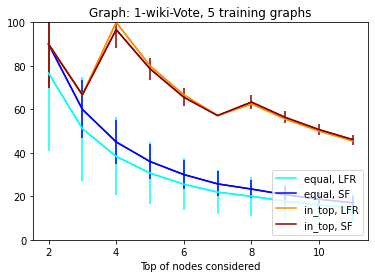

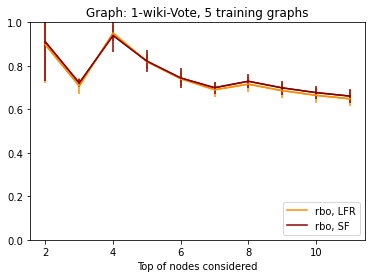

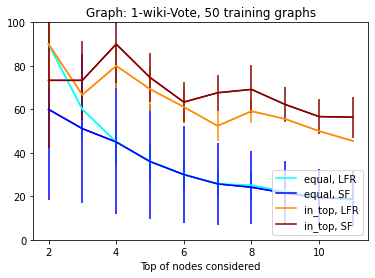

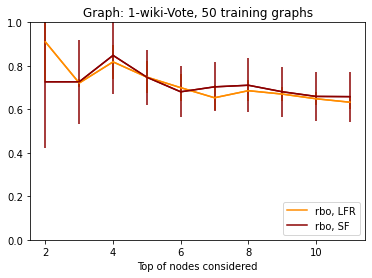

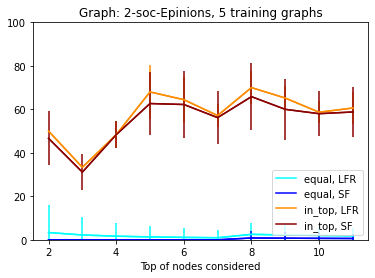

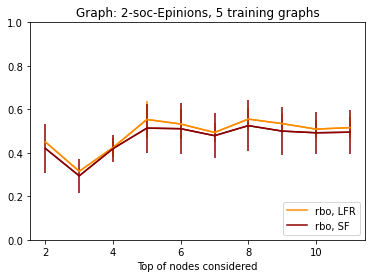

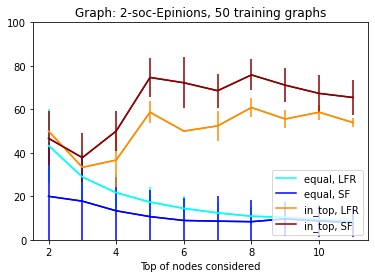

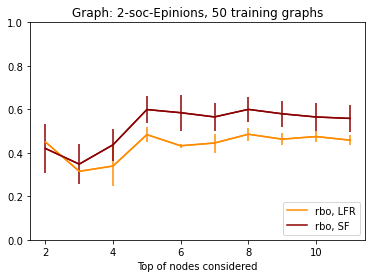

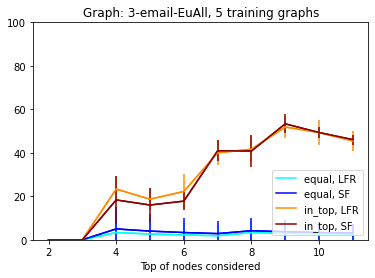

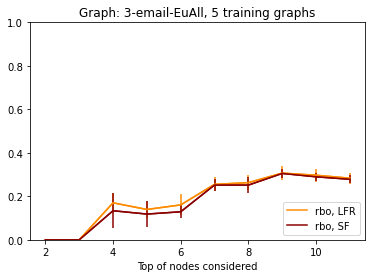

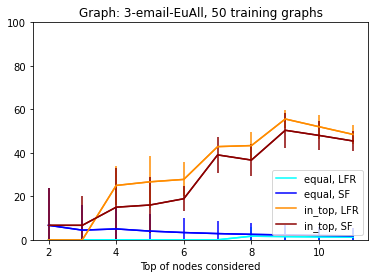

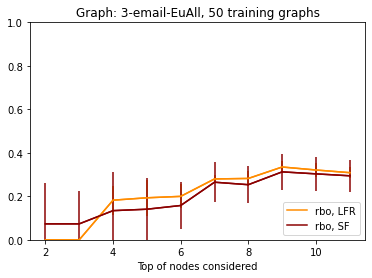

<Figure size 432x288 with 0 Axes>

In [57]:
top = 10

graphs = ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']
for graph in graphs:

    for training_graphs in [5,50]:

        file = f"testingmetrics_{training_graphs}_LFR_SF_15_seeds_top1000.pickle"

        with open(file,"rb") as fopen:
            M = pickle.load(fopen)

        metric = 'equal'
        gtype = 'LFR'
        color = 'cyan'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

        metric = 'equal'
        gtype = 'SF'
        color = 'blue'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")


        metric = 'in_top'
        gtype = 'LFR'
        color = 'darkorange'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

        metric = 'in_top'
        gtype = 'SF'
        color = 'darkred'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

        plt.title(f'Graph: {graph}, {training_graphs} training graphs')
        plt.legend(loc=4)
        plt.ylim(0,100)
        plt.xlabel("Top of nodes considered")
        plt.show()
        plt.clf()



        metric = 'rbo'
        gtype = 'LFR'
        color = 'darkorange'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

        metric = 'rbo'
        gtype = 'SF'
        color = 'darkred'
        seeds = range(15)

        xs = [j for j in M[graph][0][gtype][f'{9}_epoch'][metric].keys()][:top]
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f'{9}_epoch'][metric][j])
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color)
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

        plt.title(f'Graph: {graph}, {training_graphs} training graphs')
        plt.legend(loc=4)
        plt.ylim(0,1)
        plt.xlabel("Top of nodes considered")
        plt.show()
        plt.clf()

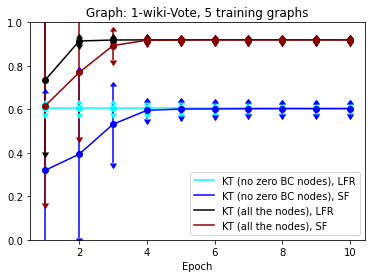

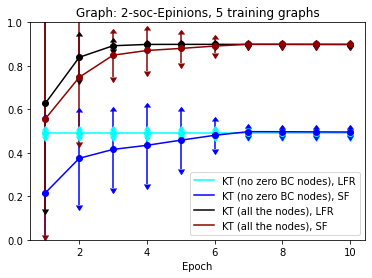

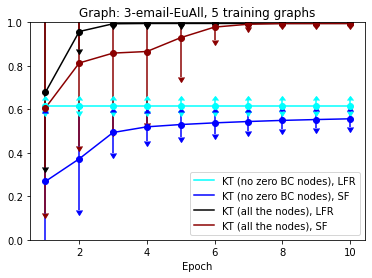

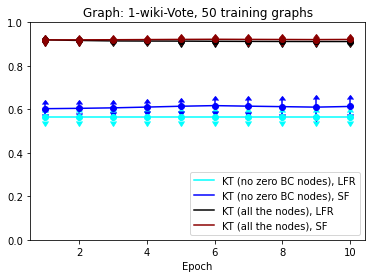

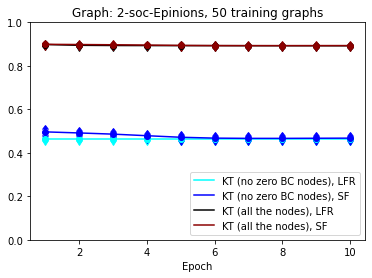

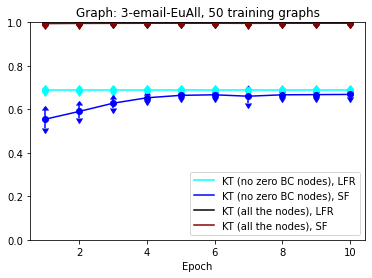

<Figure size 432x288 with 0 Axes>

In [5]:

import matplotlib.pyplot as plt
import pickle
import numpy as np

for training_graphs in [5,50]:
    
    graphs = ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']
    for graph in graphs:


        file = f"testingmetrics_{training_graphs}_LFR_SF_15_seeds_top1000.pickle"

        with open(file,"rb") as fopen:
            M = pickle.load(fopen)


        metric = 'nozeroskendall'
        labelmetric = 'KT (no zero BC nodes)'
        gtype = 'LFR'
        color = 'cyan'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for i in xs:
            j=10
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")


        metric = 'nozeroskendall'
        labelmetric = 'KT (no zero BC nodes)'
        gtype = 'SF'
        color = 'blue'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")

        metric = 'fullkendall'
        labelmetric = 'KT (all the nodes)'
        gtype = 'LFR'
        color = 'black'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")


        metric = 'fullkendall'
        labelmetric = 'KT (all the nodes)'
        gtype = 'SF'
        color = 'darkred'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{labelmetric}, {gtype}")

        plt.title(f'Graph: {graph}, {training_graphs} training graphs')
        plt.legend(loc=4)
        plt.ylim(0,1)
        plt.xlabel("Epoch")
        

        plt.show()
        plt.clf()

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


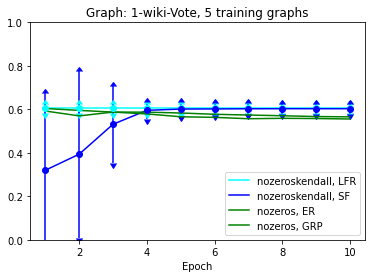

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


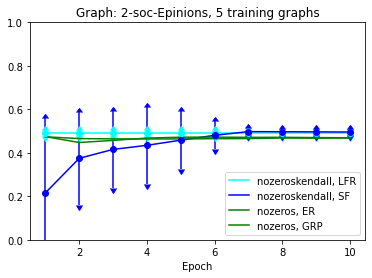

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


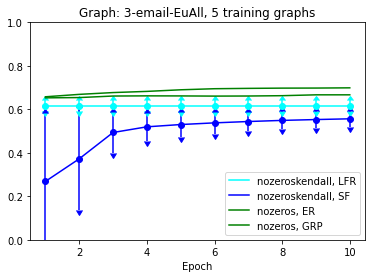

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


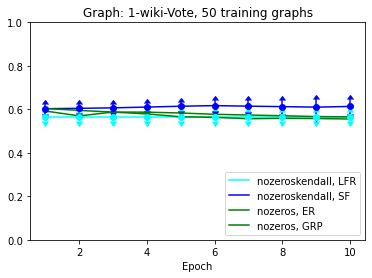

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


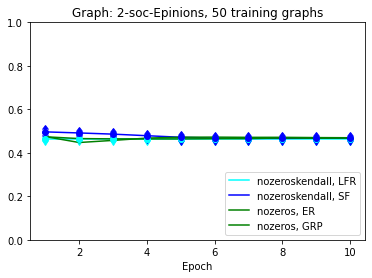

dict_keys(['ER', 'GRP'])
dict_keys(['ER', 'GRP'])


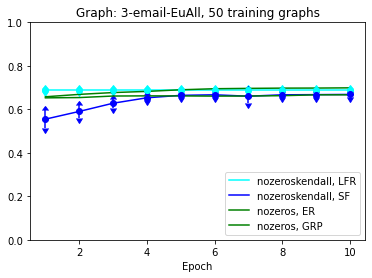

<Figure size 432x288 with 0 Axes>

In [56]:
# considering er and grp


import matplotlib.pyplot as plt

for training_graphs in [5,50]:
    
    graphs = ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']
    for graph in graphs:


        file = f"testingmetrics_{training_graphs}_LFR_SF_15_seeds_top1000.pickle"
        file2 = "output_real_graphs_peformance_full_ER_GRP_nozeros.pickle"
        with open(file,"rb") as fopen:
            M = pickle.load(fopen)
        with open(file2,"rb") as fopen:
            M2 = pickle.load(fopen)

        metric = 'nozeroskendall'
        gtype = 'LFR'
        color = 'cyan'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for i in xs:
            j=10
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")


        metric = 'nozeroskendall'
        gtype = 'SF'
        color = 'blue'
        seeds = range(15)

        xs = range(1,11)
        ys = []
        err = []
        for j in xs:
            aux = []
            for seed in seeds:
                aux.append(M[graph][seed][gtype][f"{j-1}_epoch"][metric][0])
                
            ys.append(np.mean(np.array(aux)))
            err.append(np.std(np.array(aux)))
        plt.errorbar(xs,ys,err,c=color,uplims=True, lolims=True, fmt='o')
        plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")


        metric = 'nozeroskendall'
        for gtype in ['ER','GRP']:
            print(M2[graph].keys())
            color = 'green'
            xs = range(1,11)
            ys = [M2[graph][gtype]["1_seed"]["40_copies"][f"{j-1}_epoch"]["nozeroskt"] for j in xs]
            plt.plot(xs,ys, c=color, label = f"nozeros, {gtype}")
        
        plt.title(f'Graph: {graph}, {training_graphs} training graphs')
        plt.legend(loc=4)
        plt.ylim(0,1)
        plt.xlabel("Epoch")
        plt.show()
        plt.clf()

# Analysing how much zero nodes are identified  beforehand

In [4]:
# Real bet zero values

import pickle

with open(f"real_performance_full_50_generated_train_graphs_30_seeds.pickle",'rb') as f:
    data = pickle.load(f)

for g in list(data.keys()):
    
    r = data[g]['LFR'][f'{list(data[g]["LFR"].keys())[0]}']['real']
    n = len(r)

    zeros = 0
    for v in r:
        if v == 0:
            zeros += 1

    print(f"Graph: {g}, Nodes: {n}, Found zeros (bet): {zeros} ({zeros/n*100} %), No zeros: {n-zeros} ({(n-zeros)/n*100} %)")

Graph: 1-wiki-Vote, Nodes: 7115, Found zeros (bet): 4711 (66.21222768798314 %), No zeros: 2404 (33.78777231201687 %)
Graph: 2-soc-Epinions, Nodes: 75879, Found zeros (bet): 50540 (66.60604383294456 %), No zeros: 25339 (33.39395616705544 %)
Graph: 3-email-EuAll, Nodes: 265214, Found zeros (bet): 258884 (97.61324816940282 %), No zeros: 6330 (2.386751830597178 %)


In [40]:
# zeros beforehand 

from utils import *

param = {
    "graphs": ['1-wiki-Vote','2-soc-Epinions','3-email-EuAll'],
    "sizes" : [10000,100000,300000],
    "copies": [1],
}
for i in range(len(param["graphs"])):

    g = param["graphs"][i]
    size = param["sizes"][i]
    data_test = f'{g}_{size}_size.pickle'

    #Load test data
    with open("./data_splits/test/"+data_test,"rb") as fopen:
        list_graph_test,list_n_seq_test,list_num_node_test,bc_mat_test,deg_mat_test = pickle.load(fopen)

    print(np.shape(bc_mat_test))
    s = np.shape(bc_mat_test)[0]
    for idx,val in enumerate(list_num_node_test):
        count = 0
        for j in list(bc_mat_test[:,idx]):
            if j == 0:
                count += 1
        print(f"nodes: {val}, extra: {s-val}, total_zeros: {count}, zeros: {(count-(s-val))}")
        #print(val, val - len(np.nonzero(bc_mat_test[:val,0].flatten())[0]))

        
    list_adj_test,list_adj_t_test = graph_to_adj_bet(list_graph_test,list_n_seq_test,list_num_node_test,size)


(10000, 1)
nodes: 7115, extra: 2885, total_zeros: 7596, zeros: 4711
Processing graphs: 1/1
Graph 0, Nodes: 7115, Beforehand zeros: 4711 (66.21222768798314 %)
(100000, 1)
nodes: 75879, extra: 24121, total_zeros: 74661, zeros: 50540
Processing graphs: 1/1
Graph 0, Nodes: 75879, Beforehand zeros: 50540 (66.60604383294456 %)
(300000, 1)
nodes: 265214, extra: 34786, total_zeros: 293670, zeros: 258884
Processing graphs: 1/1
Graph 0, Nodes: 265214, Beforehand zeros: 258884 (97.61324816940282 %)


In [44]:
from utils import *

for gtype in ['ER','SF','GRP']:
    
    print(gtype)

    file = f"{gtype}_10_graphs_10000_5000_nodes_10000_size.pickle"
    size = 10000
    
    #Load test data
    with open("./data_splits/test/"+file,"rb") as fopen:
        list_graph_test,list_n_seq_test,list_num_node_test,bc_mat_test,deg_mat_test = pickle.load(fopen)

    print(np.shape(bc_mat_test))
    s = np.shape(bc_mat_test)[0]
    for idx,val in enumerate(list_num_node_test):
        count = 0
        for j in list(bc_mat_test[:,idx]):
            if j == 0:
                count += 1
        print(f"nodes: {val}, extra: {s-val}, total_zeros: {count}, zeros: {(count-(s-val))}")
        #print(val, val - len(np.nonzero(bc_mat_test[:val,idx].flatten())[0]))
        
    list_adj_test,list_adj_t_test = graph_to_adj_bet(list_graph_test,list_n_seq_test,list_num_node_test,size)

ER
(10000, 10)
nodes: 9059, extra: 941, total_zeros: 1460, zeros: 519
nodes: 9025, extra: 975, total_zeros: 1433, zeros: 458
nodes: 8214, extra: 1786, total_zeros: 1921, zeros: 135
nodes: 7065, extra: 2935, total_zeros: 2945, zeros: 10
nodes: 6286, extra: 3714, total_zeros: 3716, zeros: 2
nodes: 8791, extra: 1209, total_zeros: 1213, zeros: 4
nodes: 7912, extra: 2088, total_zeros: 2144, zeros: 56
nodes: 9556, extra: 444, total_zeros: 2893, zeros: 2449
nodes: 9822, extra: 178, total_zeros: 227, zeros: 49
nodes: 5088, extra: 4912, total_zeros: 5087, zeros: 175
Processing graphs: 1/10
Graph 0, Nodes: 9059, Beforehand zeros: 519 (5.729109173197925 %)
Processing graphs: 2/10
Graph 1, Nodes: 9025, Beforehand zeros: 458 (5.0747922437673125 %)
Processing graphs: 3/10
Graph 2, Nodes: 8214, Beforehand zeros: 135 (1.643535427319211 %)
Processing graphs: 4/10
Graph 3, Nodes: 7065, Beforehand zeros: 10 (0.14154281670205238 %)
Processing graphs: 5/10
Graph 4, Nodes: 6286, Beforehand zeros: 2 (0.03181